**Important!!!** 

Checks to do:

- initial state given to the KF is similar to the first couple of radar measurements
- ukf.predict(dt = dt) where dt is the varying timestep


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
# import numpy as np
import math
from numpy.random import randn
from scipy.integrate import solve_ivp
from math import atan2


In [2]:
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_EARTH = 5.972e24  # Mass of Earth (kg)
R_EARTH = 6371e3  # Radius of Earth (m)
ATMOSPHERE_HEIGHT = 120e3  # Approximate height of the atmosphere (m)
CD = 2.2  # Drag coefficient (dimensionless)
A = 1.0  # Cross-sectional area of the satellite (m^2)
M_SAT = 500  # Mass of the satellite (kg)
RHO_0 = 1.225  # Air density at sea level (kg/m^3)
H_SCALE = 8500  # Scale height of the atmosphere (m)

In [3]:
class SatelliteTraj: 
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std 
        
    def update(self, dt):
        """Compute next position using RK45 with dynamics inside."""
        def atmospheric_density(altitude):
            if altitude > 0:
                return RHO_0 * np.exp(-altitude / H_SCALE)
            else:
                return 0
    
        def dynamics(t, state):
            x, y, z, vx, vy, vz = state
            r = np.sqrt(x**2 + y**2 + z**2)
            altitude = r - R_EARTH
            if altitude <= 0:
                raise RuntimeError("Satellite has already reentered or impacted the ground.")

            # Gravity
            a = -G * M_EARTH / r**2
            # a = a*5        # try increase acceleration

            # Drag
            rho = atmospheric_density(altitude)
            v = np.sqrt(vx**2 + vy**2 + vz**2)
            F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
            F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
            F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT

            ax = a * x/r + F_drag_x
            ay = a * y/r + F_drag_y
            az = a * z/r + F_drag_z
            
            return [vx, vy, vz, ax, ay, az]
        
        def stop_condition(t, y):
            # Stop when altitude <= 0
            if t == 0:
                return 1.0  # Don't trigger at initial step
            x,y,z = y[:3]
            r = np.sqrt(x**2 + y**2 + z**2)
            altitude = r - R_EARTH
            return altitude

        stop_condition.terminal = True
        stop_condition.direction = -1
        state0 = np.hstack((self.pos, self.vel))
        sol = solve_ivp(dynamics, [0, dt], state0, method='RK45', t_eval=[dt], events=stop_condition, rtol=1e-5, atol=1e-2)
        
        sol_y = np.asarray(sol.y)
        # print(sol_y)
        # print(sol_y[:, -1])
        if sol.success and sol_y.size > 0:
            new_state = sol_y[:, -1]
            # print(f"sol.y type: {type(sol.y)}, shape: {np.shape(sol.y)}")
            # new_state = np.asarray(sol.y)[:, -1]
            self.pos = new_state[:3]
            self.vel = new_state[3:]

            # Optionally apply Gaussian noise to velocity
            if self.vel_std:
                self.vel += np.random.normal(0, self.vel_std, size=3)

            return self.pos
        else:
            print("Integration failed!")
            print(f"Status: {sol.status}")
            print(f"Message: {sol.message}")
            print(f"t: {sol.t}")
            print(f"y: {sol.y}")
            raise RuntimeError("Integration failed.")


In [125]:
sat = SatelliteTraj(pos=[R_EARTH + 1000e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0)
num_iterations = 10000
xs = []
for _ in range(num_iterations):
    # print(sat.update(10))  # simulate 10-second intervals
    xs.append(sat.update(dt = 10))

xs = np.array(xs)
# print(xs)

In [108]:
xs = np.array(xs)

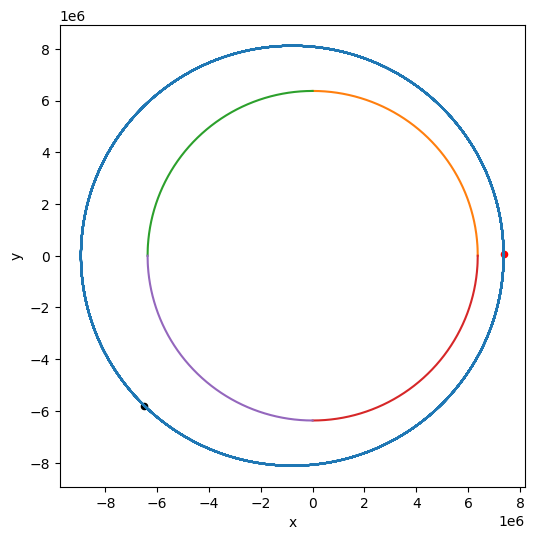

In [126]:
x_axis = np.linspace(0, R_EARTH, 1000)
y_axis = np.sqrt(R_EARTH**2-x_axis**2)
plt.figure(figsize = (6,6))
plt.plot(xs[:, 0] , xs[:, 1], label = '')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
plt.scatter(xs[0, 0] , xs[0, 1], label = 'start', color = 'red', s = 20)
plt.scatter(xs[-1, 0] , xs[-1, 1], label = 'end', color = 'black', s = 20)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

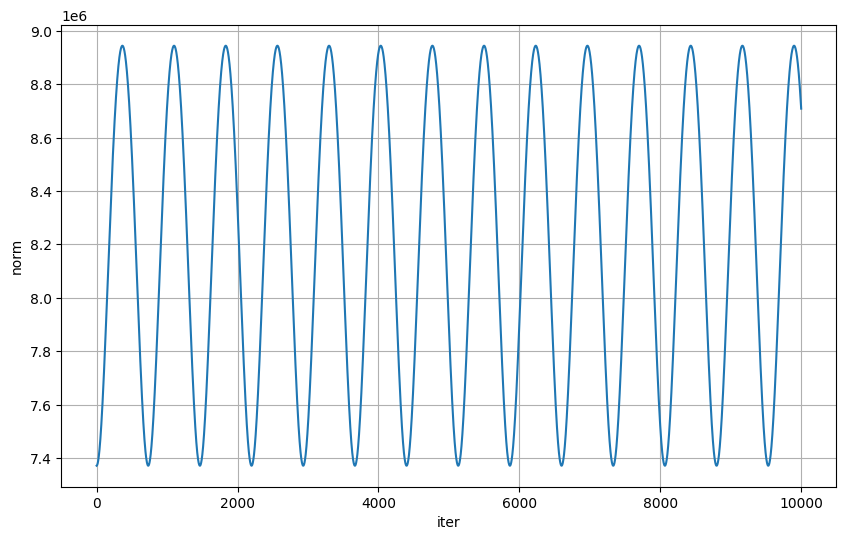

In [127]:
xs_norm = [np.linalg.norm(xs[i]) for i in range(num_iterations)]

plt.figure(figsize = (10,6))
plt.plot(xs_norm)
plt.xlabel('iter')
plt.ylabel('norm')
plt.title('')
# plt.legend()
plt.grid()
plt.show()

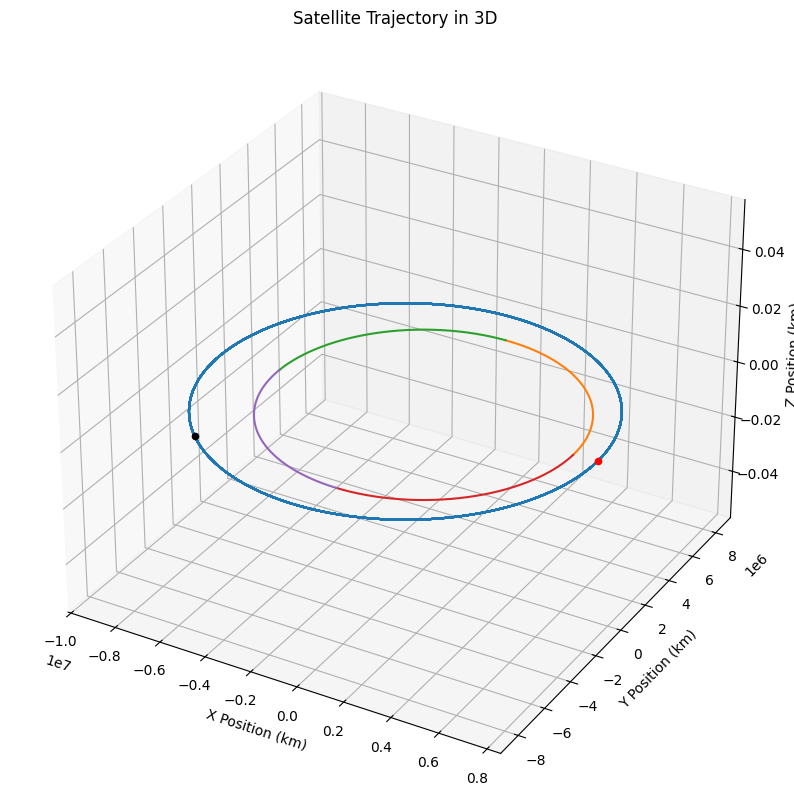

In [129]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2])
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
ax.scatter(xs[0, 0] , xs[0, 1], xs[0, 2], label = 'start', color = 'red', s = 20)
ax.scatter(xs[-1, 0] , xs[-1, 1], xs[-1, 2], label = 'end', color = 'black', s = 20)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
plt.show()

# Get the radar measurment

In [4]:
def h_radar(x):
    """x is the state vector,
    this H function assumes radar sends positions in global coordinate system"""
    # dx = x[0] - h_radar.radar_pos[0]
    # dy = x[2] - h_radar.radar_pos[1]
    # slant_range = math.sqrt(dx**2 + dy**2)
    # elevation_angle = math.atan2(dy, dx)
    # return [slant_range, elevation_angle]
    return [x[0], x[2], x[4]]   # return x,y,z position

# h_radar.radar_pos = (0, 0)

In [5]:
class RadarStation:
    
    def __init__(self, pos, x_std, y_std, z_std):
        self.pos = np.asarray(pos)       
        self.x_std = x_std
        self.y_std = y_std
        self.z_std = z_std

    
    def reading_of(self, satellite_pos):
    #     """ Returns (range, elevation angle) to aircraft. 
    #     Elevation angle is in radians.
    #     """
        
    #     diff = np.subtract(ac_pos, self.pos)
    #     rng = norm(diff)
    #     brg = atan2(diff[1], diff[0])
        # return rng, brg
        return satellite_pos[0], satellite_pos[1], satellite_pos[2]


    def noisy_reading(self, satellite_pos, time):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        x,y,z = self.reading_of(satellite_pos)      
        x += randn() * self.x_std
        y += randn() * self.y_std 
        z += randn() * self.z_std
        return x,y,z, time

In [136]:
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 1000e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0001)  # true satellite position with noise
num_iterations = 1000
dt = 10.

radar = RadarStation((0,0,0), 10, 10, 10)

xs = []
zs = []
for iter in range(num_iterations):
    # print(sat.update(10))  # simulate 10-second intervals
    sate_pos = satellite_pos_true.update(dt = dt)
    xs.append(sate_pos)
    z = radar.noisy_reading(satellite_pos= sate_pos, time = (iter+1)*dt)
    zs.append(z)

xs = np.array(xs)
zs = np.array(zs)



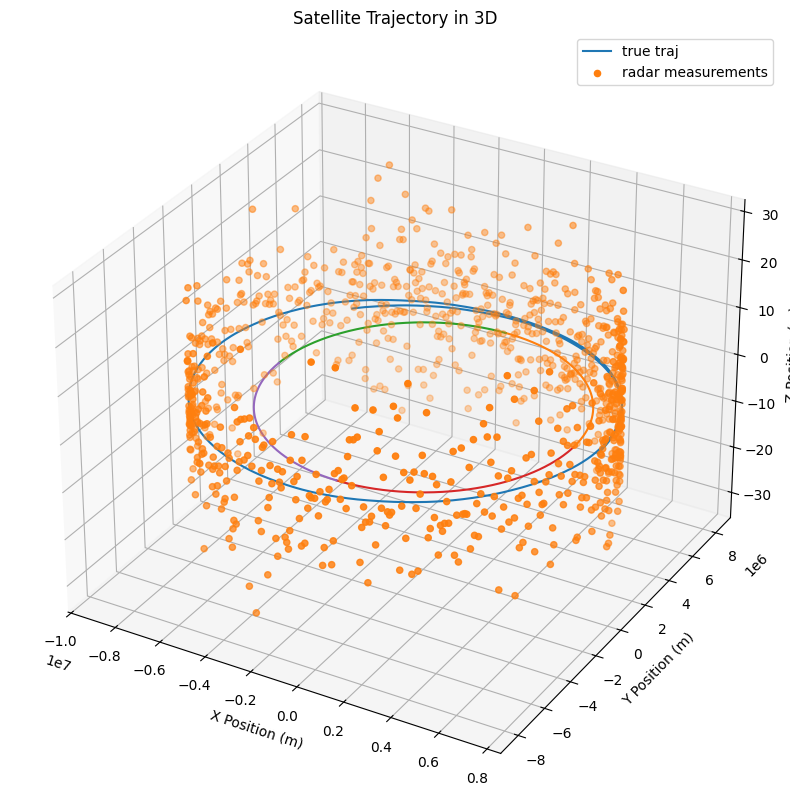

In [138]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2], label = 'true traj')
ax.scatter(zs[:, 0] , zs[:, 1], zs[:, 2], color = 'C1', label = 'radar measurements')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
# ax.set_zlim(-100, 100)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.legend()
plt.show()

# Define the process model f

In [6]:
def f(state_x, dt):
    # """state vector = state_x = [x,vx,y,vx,z,vz]"""
    # x, vx, y, vy, z, vz = state_x
    """state vector = state_x = [x,y,z,vx, vy, vz]"""
    x, y, z, vx, vy, vz = state_x
    r = np.sqrt(x**2 + y**2 + z**2)
    a = -G * M_EARTH / r**2
    # a = a*5        # try increase acceleration
    ax = a * x/r
    ay = a * y/r
    az = a * z/r

    x_new = x + vx * dt
    y_new = y + vy * dt
    z_new = z + vz * dt
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt
    # return np.array([x_new, vx_new, y_new, vy_new, z_new, vz_new])
    return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])

# Define measurement function h(x)

In [7]:
def h_radar(x):
    """x is the state vector,
    this H function assumes radar sends positions in global coordinate system"""
    # return [x[0], x[2], x[4]]   # return x,y,z position if state order is (x, vx, y, vy, z, vz)
    return x[:3] # return x,y,z position if state order is (x,y,z,vx,vy,vz)



# Unscented KF

In [250]:
Q_discrete_white_noise(dim=2, dt=1, var=1)

array([[0.25, 0.5 ],
       [0.5 , 1.  ]])

In [9]:
# """ =============== Generate sigma points ================="""
# ### initialise UKF
# sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta = 2., kappa= -3.)  #kappa = -3.
# ukf = UKF(dim_x=6, dim_z=3, fx = f, hx = h_radar, dt = dt, points=sigmas_generator) # take f, h from Jai and Vijay
# # print(ukf.Q)


# ### Define items in UKF ============================
# ### initial state values of (x,y,z,vx,vy,vz)
# ukf.x = np.array([R_EARTH + 400e3, 1, -1,
#                   1, 7700, 1])  # initial state

# ukf.P = np.diag([50**2, 50**2, 50**2,
#                  5**2, 5**2, 5**2])    # experiment this

# ukf.Q = np.zeros((6,6))
# ukf.Q[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for x and vx
# ukf.Q[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for y and vy
# ukf.Q[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for z and vz



# # range_std = 10 # meters. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
# # elev_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
# # azim_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!1 (get from radar)
# # ukf.R = np.diag([range_std**2, elev_std**2, azim_std**2])

# """### radar measurement noise (for the simple UKF only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
# x_std = 50  # meters. 
# y_std = 50  # meters.
# z_std = 10  # meters. 
# ukf.R = np.diag([x_std**2, y_std**2, z_std**2])



In [96]:
def satellite_UKF(fx, hx, dt=1.0):
    """ =============== Generate sigma points ================="""
    ### initialise UKF
    sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta = 2., kappa= -3.)  #kappa = -3.
    ukf = UKF(dim_x=6, dim_z=3, fx = fx, hx = hx, dt = dt, points=sigmas_generator) # take f, h from Jai and Vijay
    # print(ukf.Q)


    """ ============== Define items in UKF ============================"""
    ### initial state values of (x,y,z,vx,vy,vz)
    ukf.x = np.array([R_EARTH + 400e3, 1, -1,
                    1, 7700, 1])  # initial state
    ### initial uncertainty of the state
    ukf.P = np.diag([50**2, 50**2, 50**2,
                    5**2, 5**2, 5**2])    # experiment this
    ### uncertainty in the process model
    ukf.Q = np.zeros((6,6))
    ukf.Q[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for x and vx
    ukf.Q[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for y and vy
    ukf.Q[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for z and vz


    # range_std = 10 # meters. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
    # elev_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
    # azim_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!1 (get from radar)
    # ukf.R = np.diag([range_std**2, elev_std**2, azim_std**2])

    """### radar measurement noise (for the simple UKF only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
    x_std = 500  # meters. 
    y_std = 500  # meters.
    z_std = 10  # meters. 
    ukf.R = np.diag([x_std**2, y_std**2, z_std**2])

    return ukf

## Run UKF with varying time steps

In [97]:
"""Initialise satellite, radar and UKF========================"""
# np.random.seed(0)  # for reproducibility
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 1000e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0001)  # true satellite position with noise
radar = RadarStation(pos = (0,0,0), x_std=50000, y_std=50, z_std=10)
ukf = satellite_UKF(fx = f, hx = h_radar, dt=1)

"""### Run UKF with varying time steps ========================""" 
num_iterations = 15
# dt_sim = 60.
dt_sim_arr = np.random.randint(1., 80., num_iterations) ### randomely generate timesteps

xs_true = []
xs_prior = []
zs = []
xs = []
time_duration = 0.0
for iter, dt_sim in enumerate(dt_sim_arr):
    time_duration += dt_sim
    # print(sat.update(10))  # simulate 10-second intervals
    sate_pos = satellite_pos_true.update(dt = dt_sim)
    xs_true.append(sate_pos)

    ### Get radar measurement
    # sate_pos = radar.reading_of(satellite_pos=sate_pos)  # true satellite position
    z = radar.noisy_reading(satellite_pos= sate_pos, time = time_duration)
    zs.append(z)

    ### run UKF
    dt = zs[iter][-1] - zs[iter-1][-1] if iter > 0 else dt_sim
    print("iteration=", iter, "\ttimestep =", dt, "\t time duration = ", time_duration)
    ukf.predict(dt=dt)      # UKF can predict at varying timesteps
    xs_prior.append(ukf.x_prior)
    # ukf.update(z, R=ukf.R, hx=h_radar, args=None)
    ukf.update(z=z[:3], R=ukf.R, hx=h_radar)  # update with radar measurement
    x_new = ukf.x
    xs.append(ukf.x)  # store the estimated state
    # xs = np.append(xs, ukf.x)

xs_true = np.array(xs_true)
xs_prior = np.array(xs_prior)
zs = np.array(zs)
xs = np.array(xs)



iteration= 0 	timestep = 68 	 time duration =  68.0
iteration= 1 	timestep = 7.0 	 time duration =  75.0
iteration= 2 	timestep = 58.0 	 time duration =  133.0
iteration= 3 	timestep = 71.0 	 time duration =  204.0
iteration= 4 	timestep = 20.0 	 time duration =  224.0
iteration= 5 	timestep = 35.0 	 time duration =  259.0
iteration= 6 	timestep = 51.0 	 time duration =  310.0
iteration= 7 	timestep = 21.0 	 time duration =  331.0
iteration= 8 	timestep = 44.0 	 time duration =  375.0
iteration= 9 	timestep = 1.0 	 time duration =  376.0
iteration= 10 	timestep = 67.0 	 time duration =  443.0
iteration= 11 	timestep = 13.0 	 time duration =  456.0
iteration= 12 	timestep = 16.0 	 time duration =  472.0
iteration= 13 	timestep = 34.0 	 time duration =  506.0
iteration= 14 	timestep = 24.0 	 time duration =  530.0


# Plot

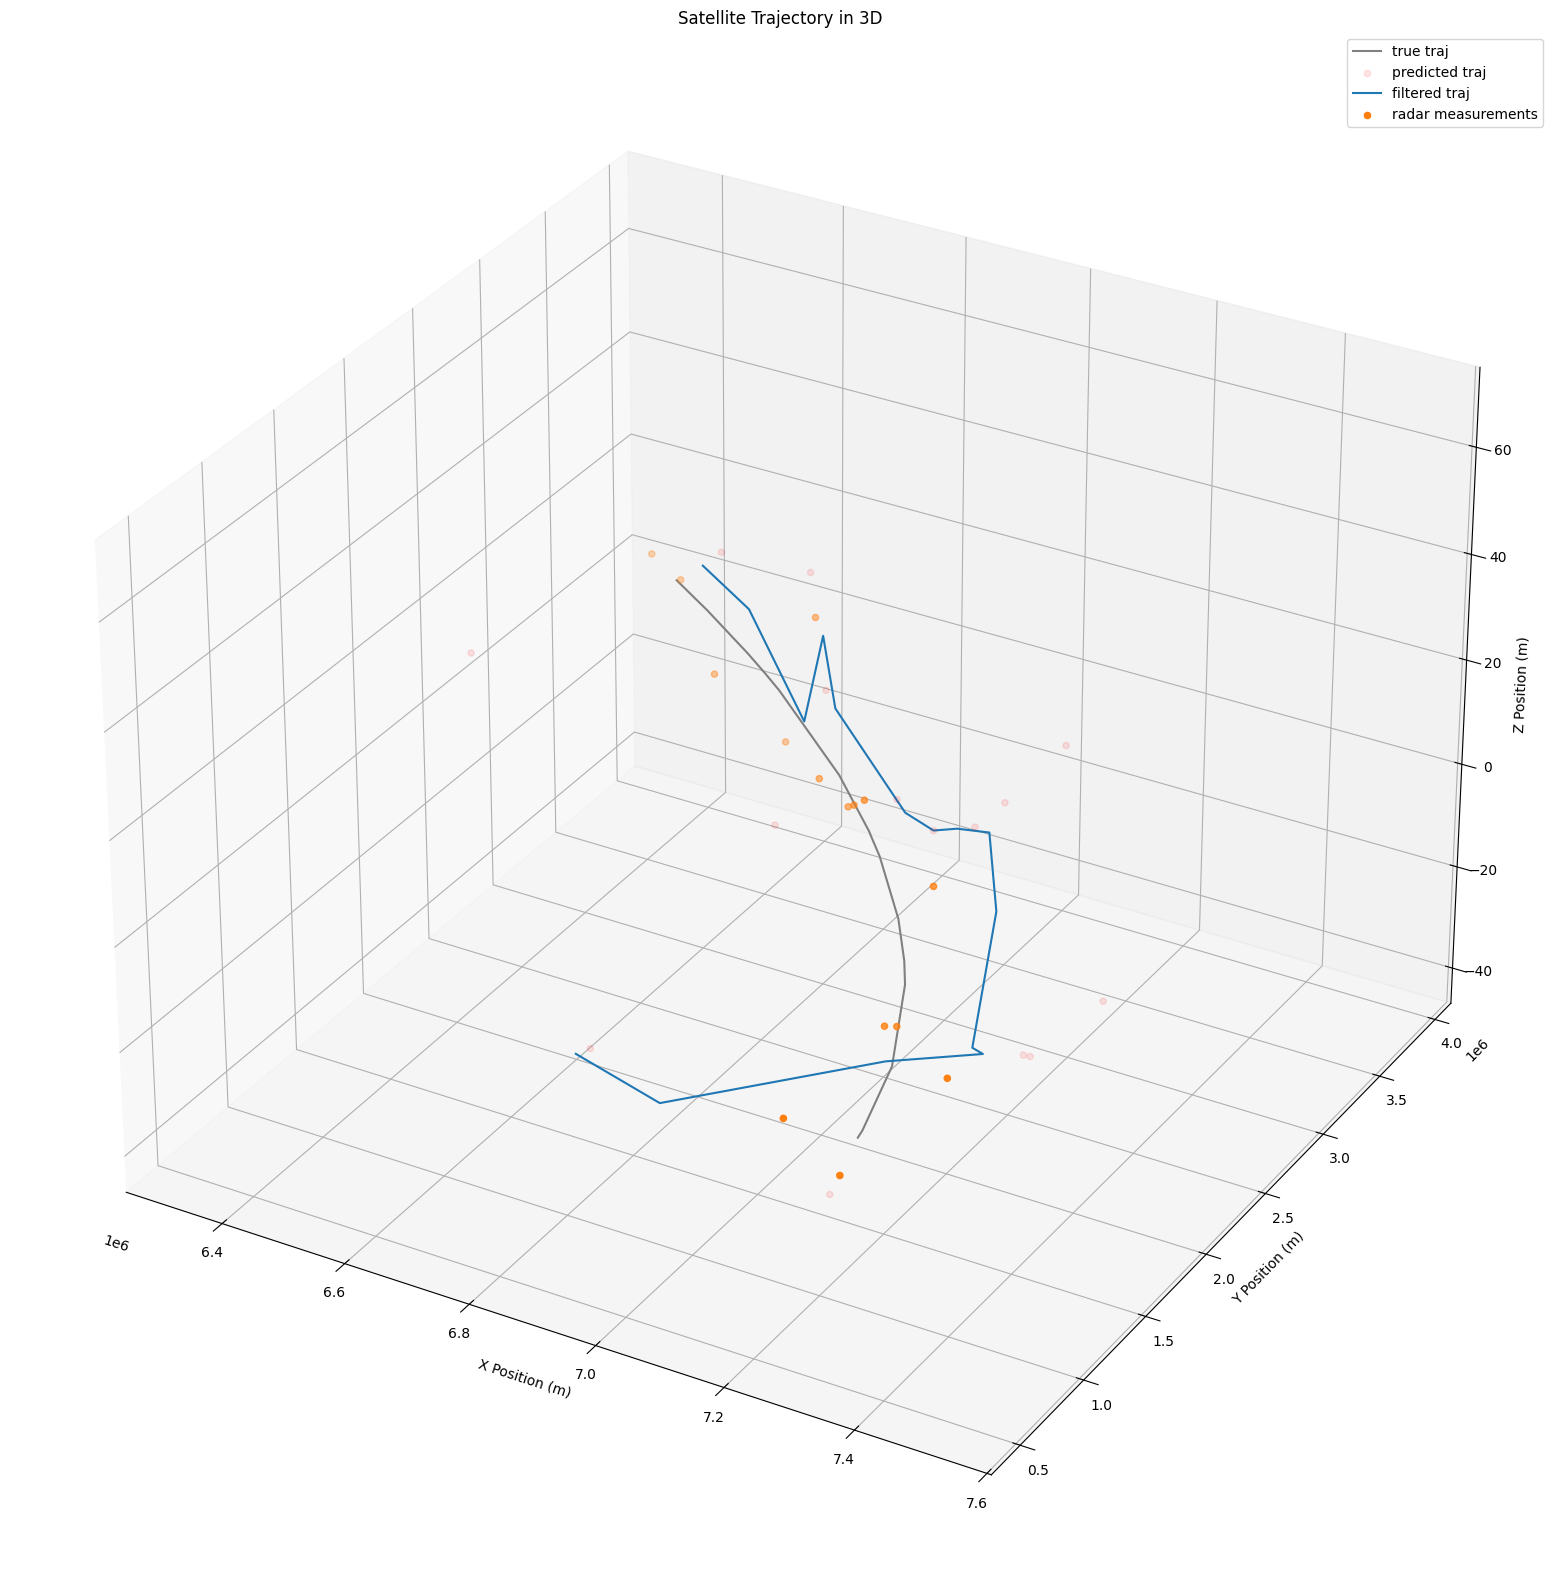

In [98]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs_true[:, 0] , xs_true[:, 1], xs_true[:, 2], color = 'grey', label = 'true traj')
ax.scatter(xs_prior[:, 0] , xs_prior[:, 1], xs_prior[:, 2], color = 'red', alpha = 0.1, label = 'predicted traj')

ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2], label = 'filtered traj')
ax.scatter(zs[:, 0] , zs[:, 1], zs[:, 2], color = 'C1', label = 'radar measurements')
# ax.set_zlim(-10, 10)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.legend()
plt.show()

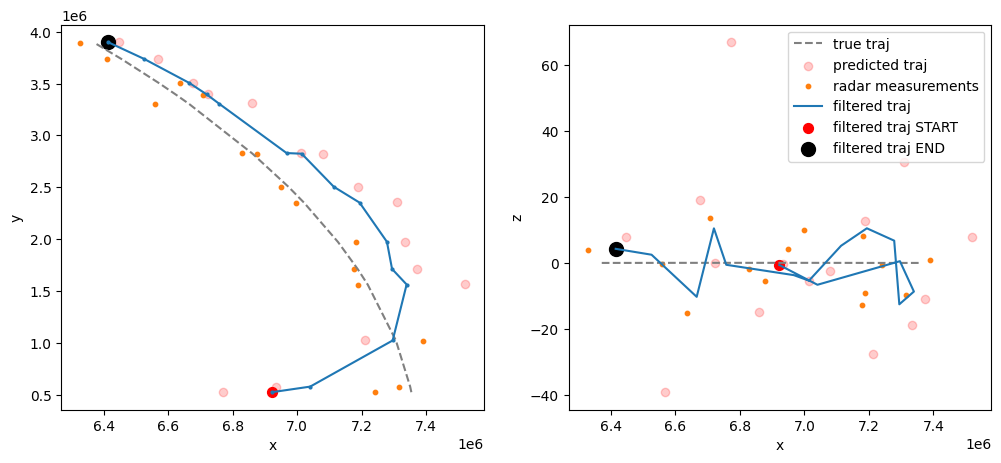

In [101]:
# plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1,2, figsize = (12, 5), sharex = True)

# plt.plot(xs_true[:, 0] , xs_true[:, 1], label = '')
ax[0].plot(xs_true[:, 0] , xs_true[:, 1], '--', color = 'grey', label = 'true traj')
ax[0].scatter(xs_prior[:, 0] , xs_prior[:, 1], color = 'red', alpha = 0.2, label = 'predicted traj')
ax[0].scatter(zs[:, 0] , zs[:, 1], color = 'C1', s = 10, label = 'radar measurements')
ax[0].plot(xs[:, 0] , xs[:, 1], "-o", markersize=2, label = 'filtered traj')
ax[0].scatter(xs[0, 0] , xs[0, 1], color = 'red', s=50, label = 'filtered traj START')
ax[0].scatter(xs[-1, 0] , xs[-1, 1], color = 'black', s=100, label = 'filtered traj END')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(xs_true[:, 0] , xs_true[:, 2], '--', color = 'grey', label = 'true traj')
ax[1].scatter(xs_prior[:, 0] , xs_prior[:, 2], color = 'red', alpha = 0.2, label = 'predicted traj')
ax[1].scatter(zs[:, 0] , zs[:, 2], color = 'C1', s = 10, label = 'radar measurements')
ax[1].plot(xs[:, 0] , xs[:, 2],label = 'filtered traj')
ax[1].scatter(xs[0, 0] , xs[0, 2], color = 'red', s=50, label = 'filtered traj START')
ax[1].scatter(xs[-1, 0] , xs[-1, 2], color = 'black', s=100, label = 'filtered traj END')
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

plt.title('')
plt.legend()
# plt.grid()
plt.show()

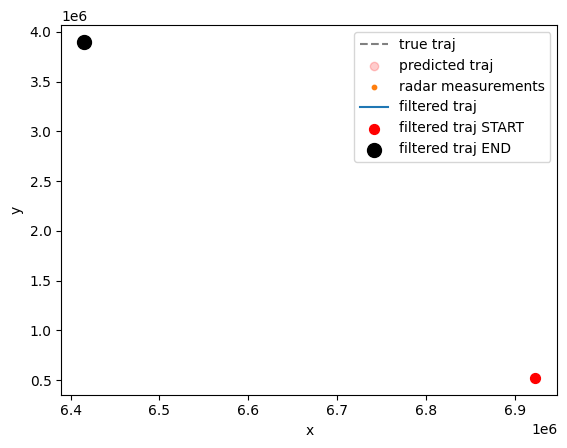

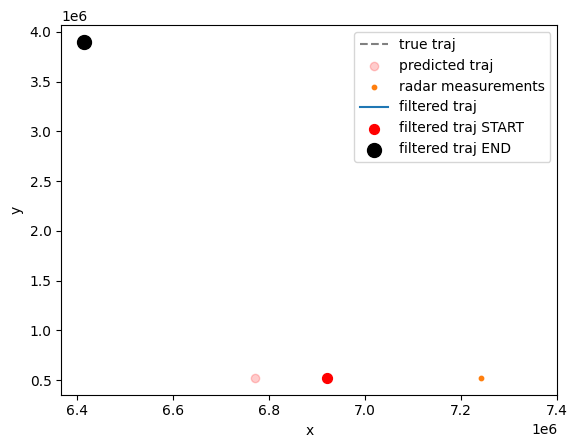

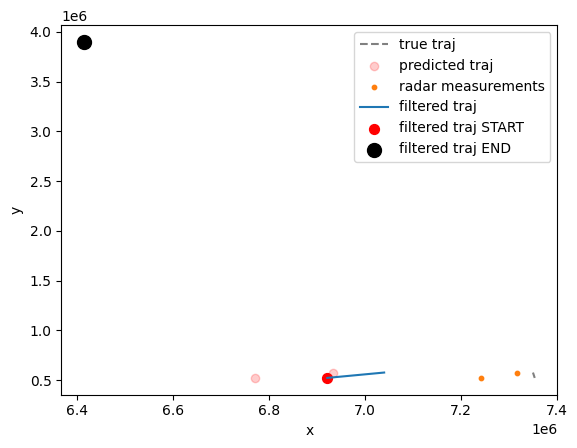

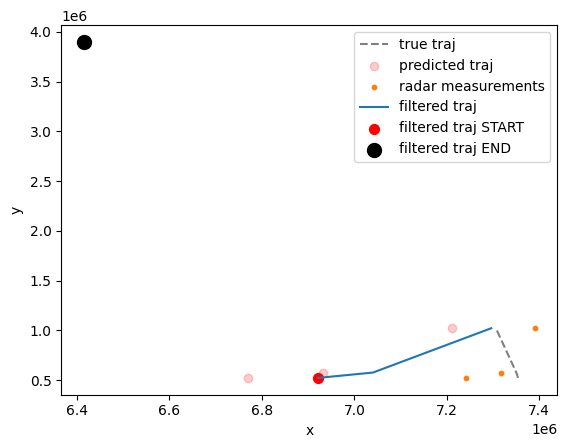

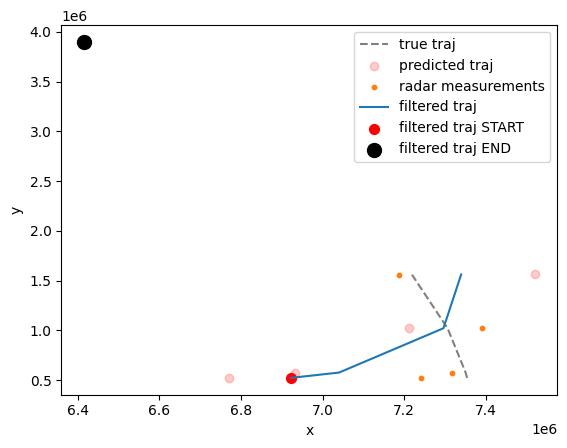

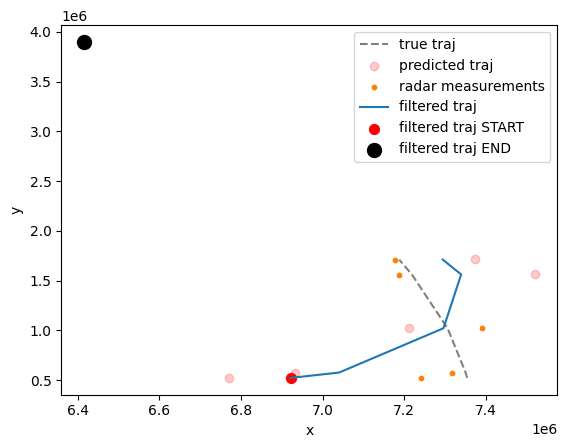

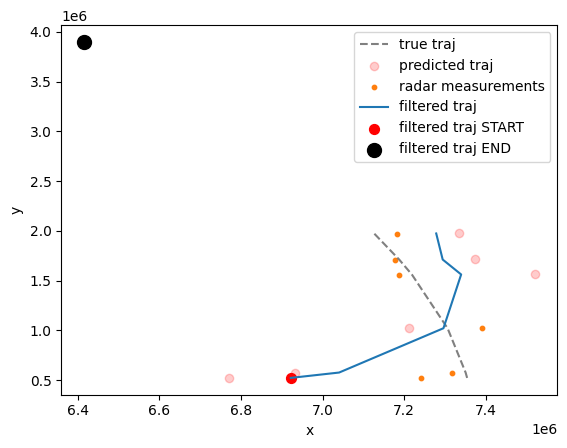

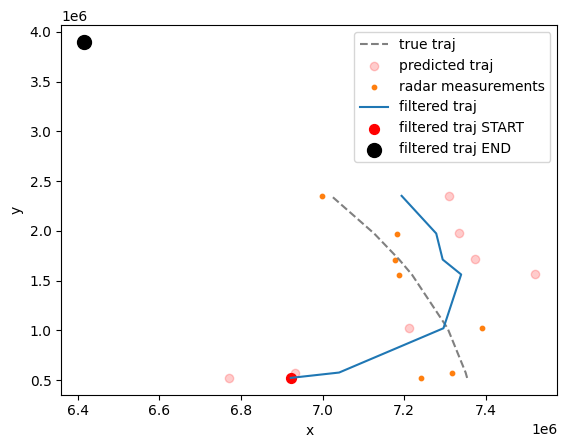

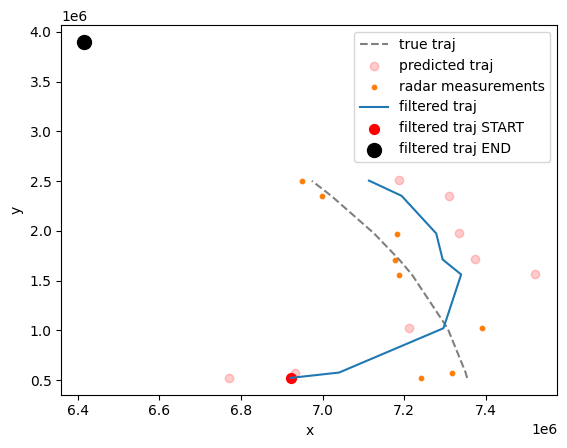

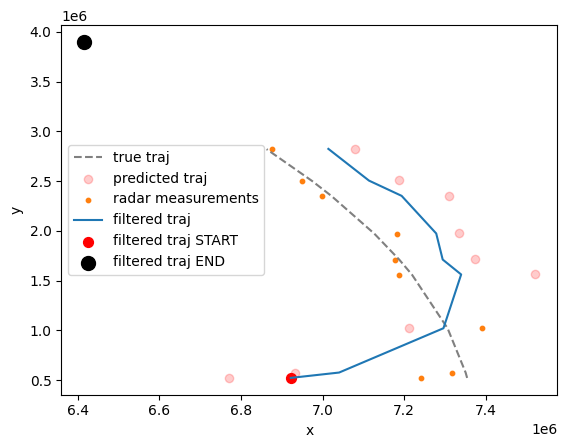

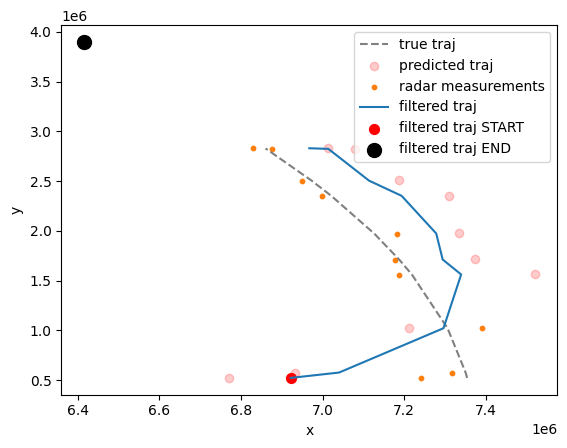

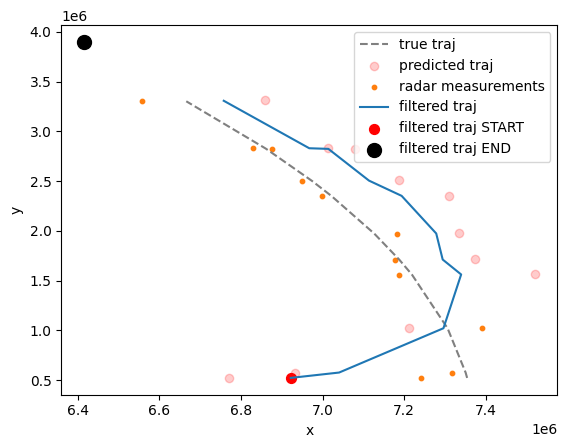

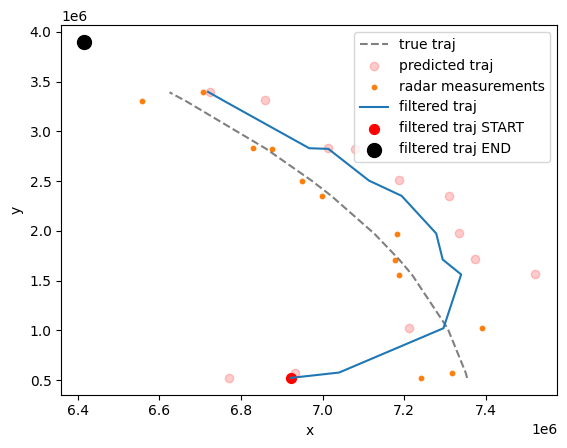

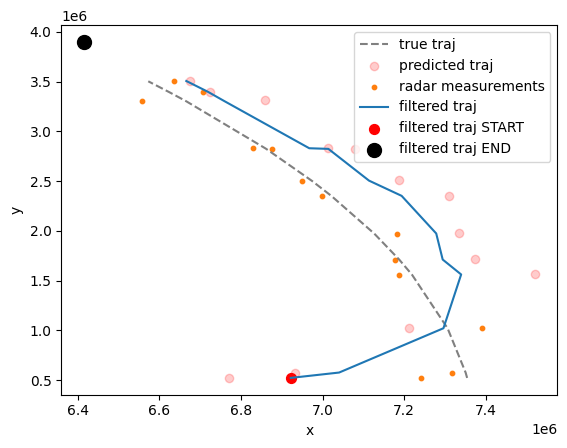

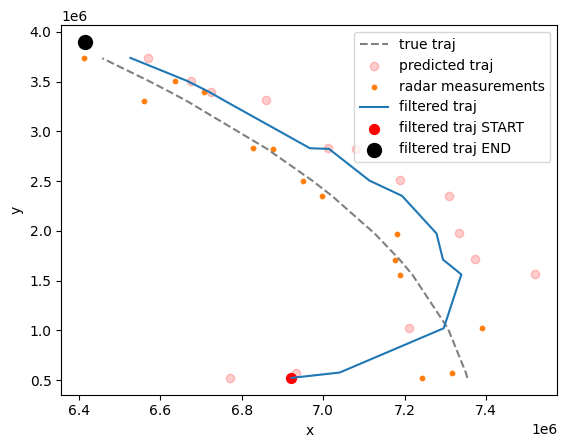

In [102]:
plt.figure()
for i in range(15):
    # plt.plot(xs_true[:, 0] , xs_true[:, 1], label = '')
    plt.plot(xs_true[:i, 0] , xs_true[:i, 1], '--', color = 'grey', label = 'true traj')
    plt.scatter(xs_prior[:i, 0] , xs_prior[:i, 1], color = 'red', alpha = 0.2, label = 'predicted traj')

    plt.scatter(zs[:i, 0] , zs[:i, 1], color = 'C1', s = 10, label = 'radar measurements')

    plt.plot(xs[:i, 0] , xs[:i, 1],label = 'filtered traj')
    plt.scatter(xs[0, 0] , xs[0, 1], color = 'red', s=50, label = 'filtered traj START')
    plt.scatter(xs[-1, 0] , xs[-1, 1], color = 'black', s=100, label = 'filtered traj END')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('')
    plt.legend()
    # plt.grid()
    plt.show()